In [2]:
import sys
import datacube
import numpy as np
import seaborn as sns
from datacube.utils import geometry
from datacube.utils.geometry import CRS

# Import external functions from dea-notebooks using relative link to Scripts
sys.path.append('../10_Scripts')
import DEADataHandling
import DEAPlotting

# Connect to datacube database
dc = datacube.Datacube(app='Snow monitoring with Landsat')


In [3]:
lat, lon, buffer_m = -36.435, 148.29, 8000
time_range = ('2017-01-01', '2018-12-31')
resolution = (-25, 25)
landsat_goodquality_prop = 0.10
ndsi_threshold = 0
ndvi_threshold = 0.3
#ndwi?


In [4]:
# Set up analysis data query using a buffer around a lat-long point.
# This converts a lat long to Australian Albers, then creates a square analysis region
# by creating a square buffer around the point.
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer_m, x + buffer_m),
         'y': (y - buffer_m, y + buffer_m),    
         'time': time_range,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution} 

# Preview area that data will be loaded for:
# DEAPlotting.display_map(y=query['y'], x=query['x'])


In [5]:
# print(query)
# print(landsat_goodquality_prop)

In [6]:
# landsat_ds_other = DEADataHandling.load_clearlandsat(dc=dc, 
#                                                product = 'nbar',
#                                                query=query,
#                                                mask_dict=snow_mask,
#                                                sensors=['ls5','ls7','ls8'],
#                                                bands_of_interest=['red', 'green', 'blue','nir', 'swir1'],
#                                                masked_prop=landsat_goodquality_prop,
#                                                mask_pixel_quality=True,
#                                                ls7_slc_off=True)

In [7]:
landsat_ds = DEADataHandling.load_clearlandsat(dc=dc, 
                                               product = 'nbart',
                                               query=query, 
                                               sensors=['ls5', 'ls7', 'ls8'],
                                               bands_of_interest=['red', 'green', 'blue','nir', 'swir1'],
                                               masked_prop=landsat_goodquality_prop,
                                               mask_pixel_quality=False,
                                               ls7_slc_off=True)
landsat_ds1 = DEADataHandling.load_clearlandsat(dc=dc, 
                                               product = 'nbar',
                                               query=query, 
                                               sensors=['ls5', 'ls7', 'ls8'],
                                               bands_of_interest=['red', 'green', 'blue', 'nir', 'swir1'],
                                               masked_prop=landsat_goodquality_prop,
                                               mask_pixel_quality=False,
                                               ls7_slc_off=True)
# print(landsat_ds)


Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Loading 42 filtered ls7 timesteps
Loading ls8
    Loading 56 filtered ls8 timesteps
Combining and sorting ls7, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Loading 42 filtered ls7 timesteps
Loading ls8
    Loading 56 filtered ls8 timesteps
Combining and sorting ls7, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


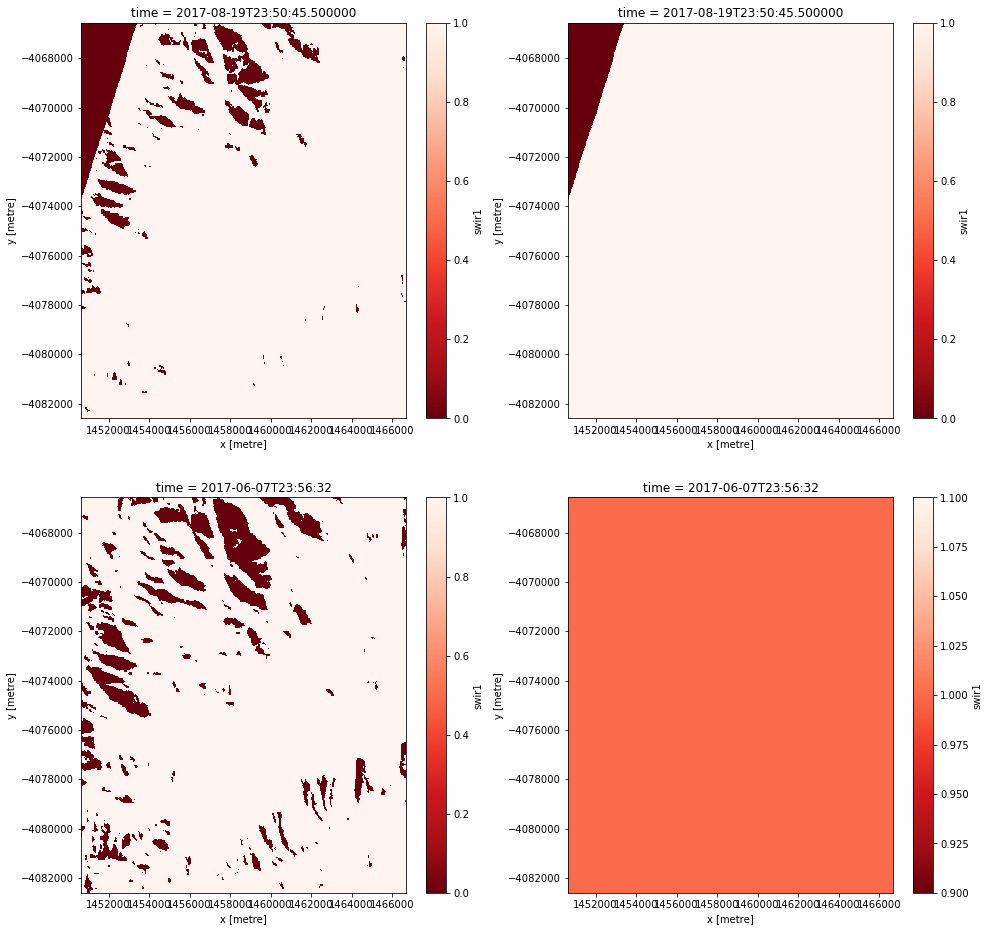

In [8]:
# Identify which pixels contain valid data in the Landsat dataset
valid_ds = np.isfinite(landsat_ds.swir1)
valid_ds1 = np.isfinite(landsat_ds1.swir1)

# Plot one sample timestep from the `valid_ds` dataset. Red below represents 
# invalid pixels, due to either issues with terrain shadow on steep mountains, 
# cloud cover, snow accidently mapped as cloud, or edges of Landsat overpasses

import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=2, nrows = 2, 
                         figsize = (16, 16)
                        )
valid_ds.isel(time=32).plot(cmap='Reds_r', ax=axes[0,0]) #37 #24
valid_ds1.isel(time=32).plot(cmap='Reds_r', ax=axes[0,1]) #37 #24
valid_ds.isel(time=24).plot(cmap='Reds_r', ax=axes[1,0]) #37 #24
valid_ds1.isel(time=24).plot(cmap='Reds_r', ax=axes[1,1]) #37 #24
# axes[0,0].set_title('nbart')
# axes[0,1].set_title('nbar')
# axes[1,0].set_title('nbart')
# axes[1,1].set_title('nbar')

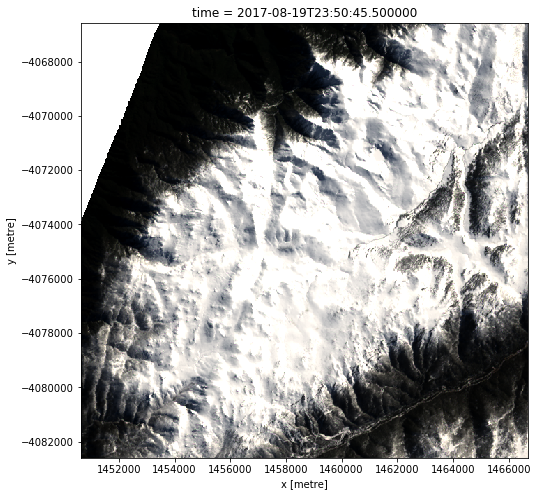

In [25]:
i=32
landsat_ds1[['red', 'green', 'blue']].isel(time=i).to_array().plot.imshow(robust=True, figsize=(8,8))

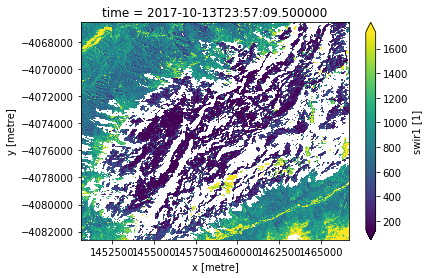

In [6]:
type(valid_ds)
# landsat_ds['swir1'].isel(time=range(138,238,20)).plot.imshow(robust=True, col='time')
landsat_ds['swir1'].isel(time=(239)).plot.imshow(robust=True)

## Compute Normalised Difference Snow Index (NDSI)

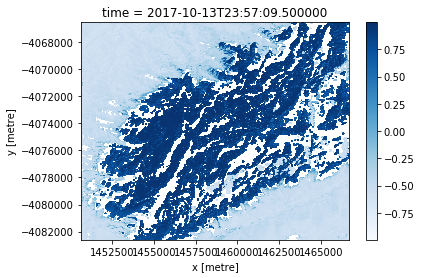

In [6]:
# Compute index by subtracting, summing and dividing the `green` and `swir` bands
ndsi_ds = (landsat_ds.green - landsat_ds.swir1) / (landsat_ds.green + landsat_ds.swir1)

# Plot one sample timestep from the NDSI dataset
ndsi_ds.isel(time=239).plot(cmap='Blues')

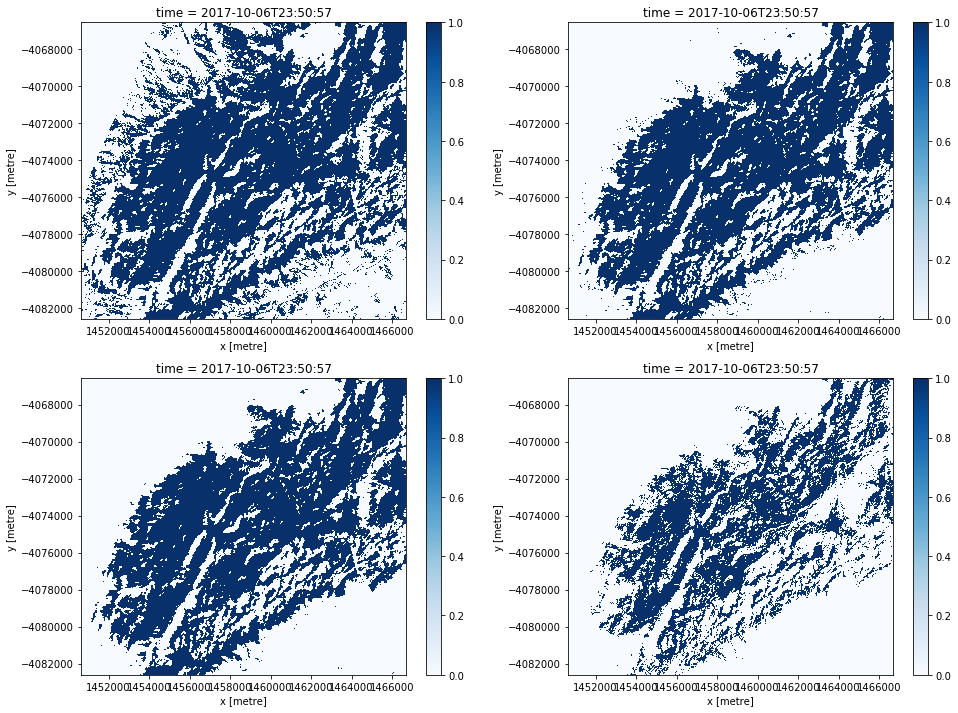

In [14]:
# Apply NDSI threshold defined above to identify snow (pixels with NDSI values greater than X)
snow_ds = ndsi_ds > -0.4 #0 #ndsi_threshold
snow_ds1 = ndsi_ds > 0 #0 #ndsi_threshold
snow_ds2 = ndsi_ds > 0.2 #0 #ndsi_threshold
snow_ds3 = ndsi_ds > 0.9 #0 #ndsi_threshold

# Plot the resulting layer
#snow_ds.isel(time=239).plot(cmap='Blues', figsize=(9, 6))

# Plot the resulting layer
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=2, nrows=2, 
                         figsize = (16, 12)
                        )

snow_ds.isel(time=238).plot(cmap='Blues', ax=axes[0,0])
snow_ds1.isel(time=238).plot(cmap='Blues', ax=axes[0,1])
snow_ds2.isel(time=238).plot(cmap='Blues', ax=axes[1,0])
snow_ds3.isel(time=238).plot(cmap='Blues', ax=axes[1,1])

## Compute Normalised Difference Vegetation Index (NDVI)

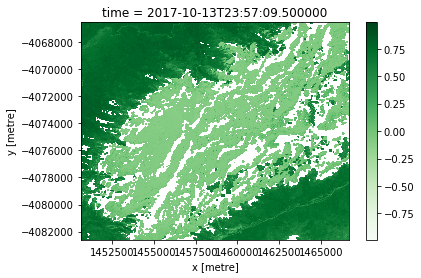

In [7]:
# Compute index by subtracting, summing and dividing the `green` and `swir` bands
ndvi_ds = (landsat_ds.nir - landsat_ds.red) / (landsat_ds.nir + landsat_ds.red)

# Plot one sample timestep from the NDSI dataset. Bright green values below 
# represent growing green vegetation
ndvi_ds.isel(time=239).plot(cmap='Greens')

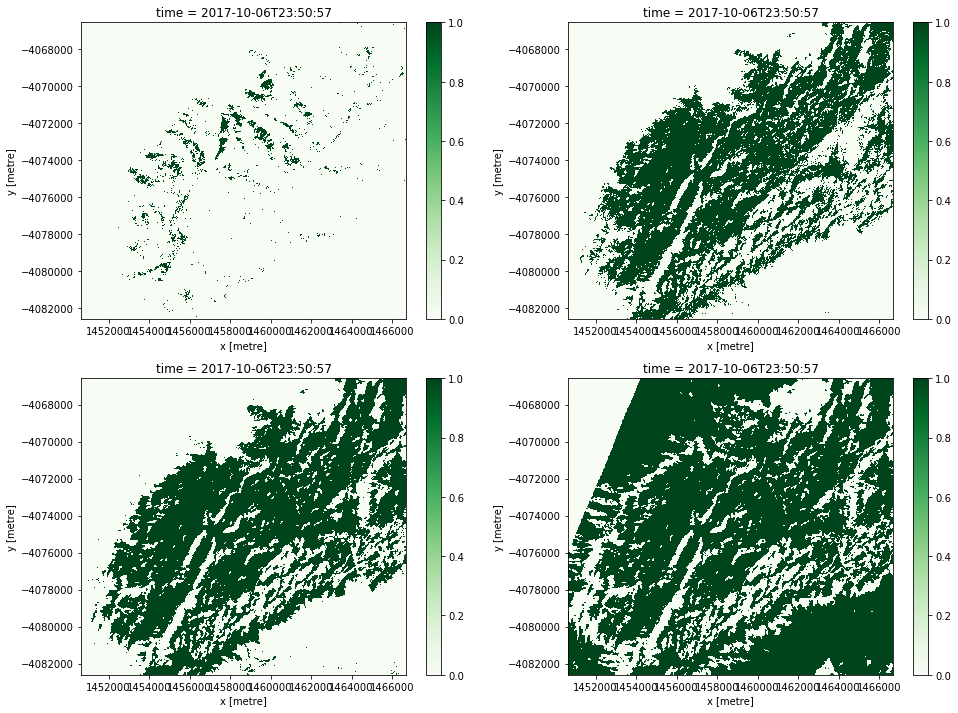

In [24]:
# Apply NDSI threshold defined above to identify snow (pixels with NDSI values greater than X)
noveg_ds = ndvi_ds < -0.1 #0 #ndvi_threshold #plots least noveg
noveg_ds1 = ndvi_ds < 0 #0 #ndvi_threshold
noveg_ds2 = ndvi_ds < 0.3 #0 #ndvi_threshold
noveg_ds3 = ndvi_ds < 0.9 #0 #ndvi_threshold #plots most noveg

# Plot the resulting layer
#snow_ds.isel(time=239).plot(cmap='Blues', figsize=(9, 6))

# Plot the resulting layer
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=2, nrows=2, 
                         figsize = (16, 12)
                        )

noveg_ds.isel(time=238).plot(cmap='Greens', ax=axes[0,0])
noveg_ds1.isel(time=238).plot(cmap='Greens', ax=axes[0,1])
noveg_ds2.isel(time=238).plot(cmap='Greens', ax=axes[1,0])
noveg_ds3.isel(time=238).plot(cmap='Greens', ax=axes[1,1])

In [ ]:
# from ESA doc (based on Dozier & Painter 2004)
# if NDSI > 0.4 and p(nir) > 0.11 (um), tjem snow in open land)
# if 0.1 < NDSI < 0.4 then snow in forest

snow_ds

### Threshold NDSI and NDVI to identify snowy, non-vegetated pixels

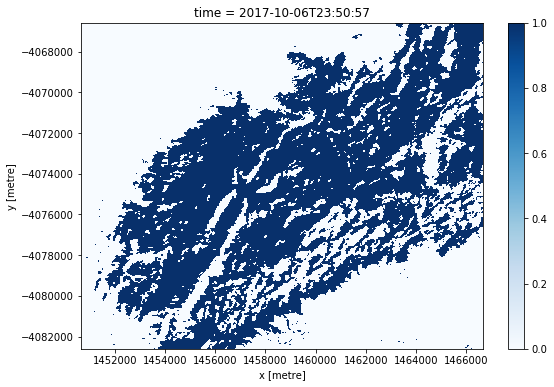

In [20]:
# Apply NDSI threshold defined above to identify snow (pixels with NDSI values greater than X)
snow_ds = ndsi_ds > 0 #0 #ndsi_threshold

# Apply NDSI threshold defined above to identify snow (pixels with NDVI values less than X)
noveg_ds = ndvi_ds <  0.3 #0.3 #ndvi_threshold

# Finally, keep only pixels that are both snowy AND non-vegetated:
#snow_ds = noveg_ds & noveg_ds
snow_ds = noveg_ds & snow_ds

# Plot the resulting layer
snow_ds.isel(time=238).plot(cmap='Blues', figsize=(9, 6))

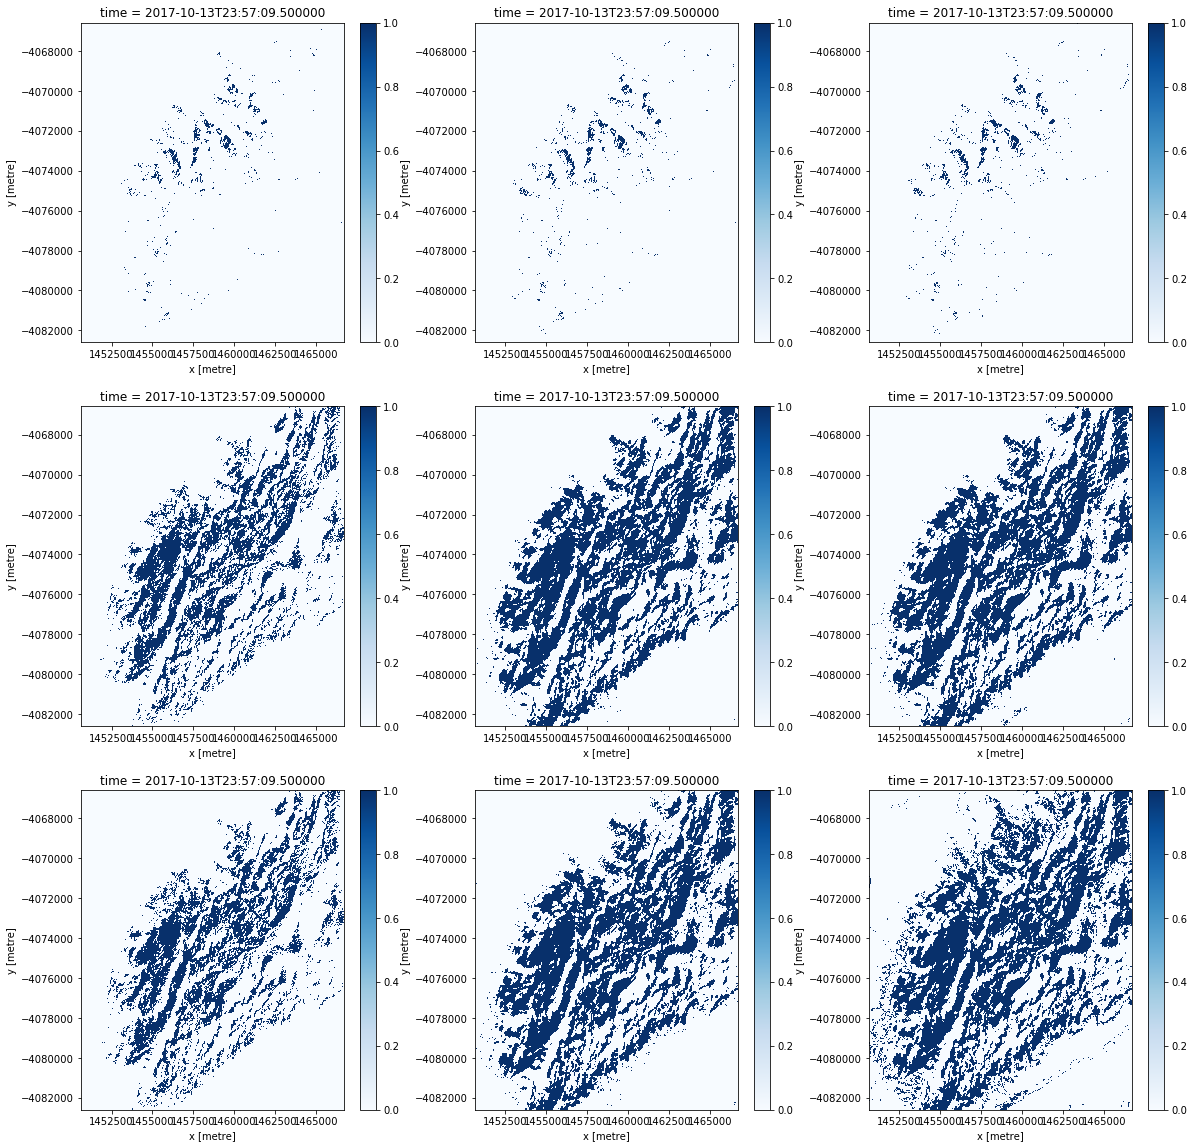

In [11]:
# Apply NDSI threshold defined above to identify snow (pixels with NDSI values greater than X)
snow_ds = ndsi_ds > 0.9 #0 #ndsi_threshold
snow_ds1 = ndsi_ds > 0
snow_ds2 = ndsi_ds > -0.4

# Apply NDSI threshold defined above to identify snow (pixels with NDVI values less than X)
noveg_ds = ndvi_ds <  -0.1 #0.3 #ndvi_threshold
noveg_ds1 = ndvi_ds < 0.3
noveg_ds2 = ndvi_ds < 0.9

# Finally, keep only pixels that are both snowy AND non-vegetated:

snow_noveg_ds = snow_ds & noveg_ds
snow_noveg_ds1 = snow_ds1 & noveg_ds
snow_noveg_ds2 = snow_ds2 & noveg_ds
snow_noveg_ds3 = snow_ds & noveg_ds1
snow_noveg_ds4 = snow_ds1 & noveg_ds1
snow_noveg_ds5 = snow_ds2 & noveg_ds1
snow_noveg_ds6 = snow_ds & noveg_ds2
snow_noveg_ds7 = snow_ds1 & noveg_ds2
snow_noveg_ds8 = snow_ds2 & noveg_ds2

snow_noveg = [snow_noveg_ds, snow_noveg_ds1, snow_noveg_ds2, snow_noveg_ds3, snow_noveg_ds4, snow_noveg_ds5, snow_noveg_ds6, snow_noveg_ds7, snow_noveg_ds8]
# Plot the resulting layer
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=3, nrows=3, figsize = (20, 20))

snow_noveg_ds.isel(time=239).plot(cmap='Blues', ax=axes[0,0])
snow_noveg_ds1.isel(time=239).plot(cmap='Blues', ax=axes[0,1])
snow_noveg_ds2.isel(time=239).plot(cmap='Blues', ax=axes[0,2])
snow_noveg_ds3.isel(time=239).plot(cmap='Blues', ax=axes[1,0])
snow_noveg_ds4.isel(time=239).plot(cmap='Blues', ax=axes[1,1])
snow_noveg_ds5.isel(time=239).plot(cmap='Blues', ax=axes[1,2])
snow_noveg_ds6.isel(time=239).plot(cmap='Blues', ax=axes[2,0])
snow_noveg_ds7.isel(time=239).plot(cmap='Blues', ax=axes[2,1])
snow_noveg_ds8.isel(time=239).plot(cmap='Blues', ax=axes[2,2])


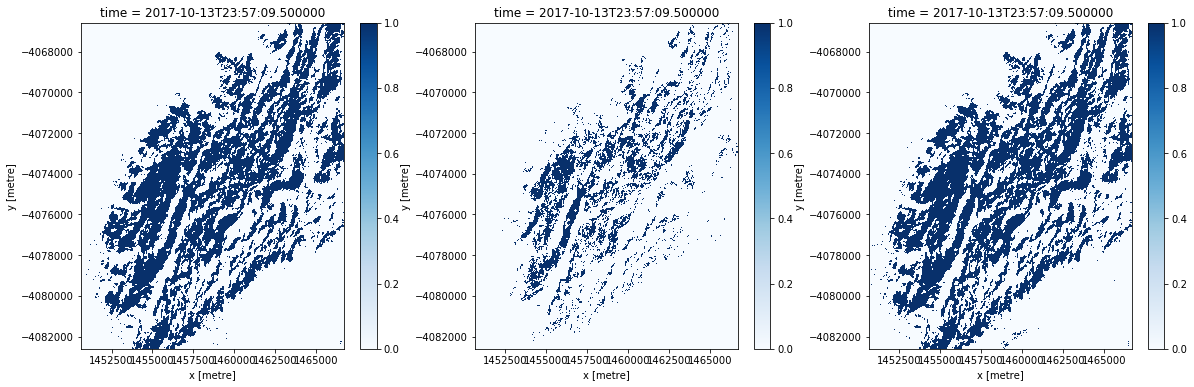

In [30]:
# Apply NDSI threshold defined above to identify snow (pixels with NDSI values greater than X)
snow_ds0 = ndsi_ds > 0 #0 #ndsi_threshold

# Apply NDSI threshold defined above to identify snow (pixels with NDVI values less than X)
noveg_ds = ndvi_ds <  0.3 #0.3 #ndvi_threshold

snow_ds1 = ndsi_ds > 0.95
snow_ds2 = ndsi_ds > -0.95
# Finally, keep only pixels that are both snowy AND non-vegetated:
snow = noveg_ds & snow_ds0

snow1 = noveg_ds & snow_ds1
snow2 = noveg_ds & snow_ds2

# Plot the resulting layer
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=3, figsize = (20, 6))

snow.isel(time=239).plot(cmap='Blues', ax=axes[0])
snow1.isel(time=239).plot(cmap='Blues', ax=axes[1])
snow2.isel(time=239).plot(cmap='Blues', ax=axes[2])

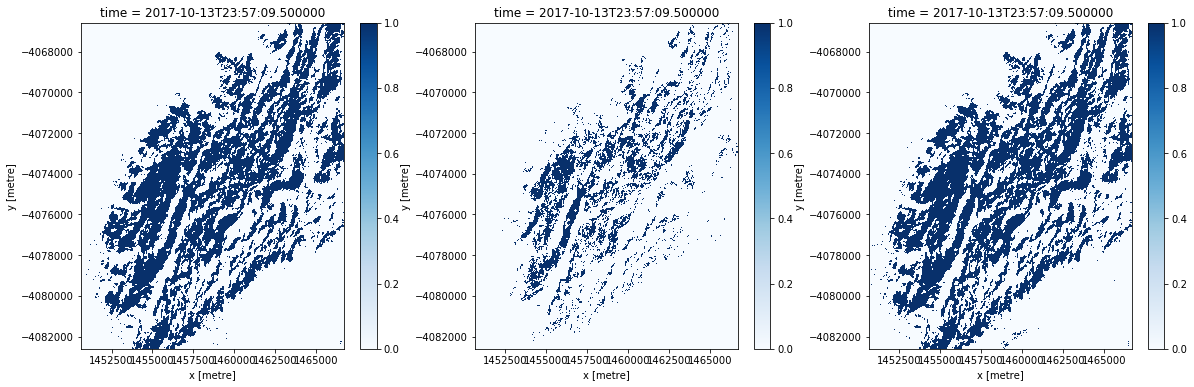

In [31]:
# Apply NDSI threshold defined above to identify snow (pixels with NDSI values greater than X)
snow_ds0 = ndsi_ds > 0 #0 #ndsi_threshold

# Apply NDSI threshold defined above to identify snow (pixels with NDVI values less than X)
noveg_ds = ndvi_ds <  0.3 #0.3 #ndvi_threshold

snow_ds1 = ndsi_ds > 0.95
snow_ds2 = ndsi_ds > -0.95
# Finally, keep only pixels that are both snowy AND non-vegetated:
snow = noveg_ds & snow_ds0

snow1 = noveg_ds & snow_ds1
snow2 = noveg_ds & snow_ds2

# Plot the resulting layer
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=3, figsize = (20, 6))

snow.isel(time=239).plot(cmap='Blues', ax=axes[0])
snow1.isel(time=239).plot(cmap='Blues', ax=axes[1])
snow2.isel(time=239).plot(cmap='Blues', ax=axes[2])

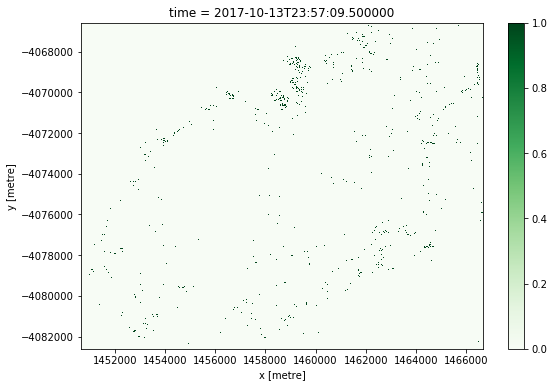

In [29]:
# from ESA doc (based on Dozier & Painter 2004)
# if NDSI > 0.4 and p(nir) > 0.11 (um), tjem snow in open land)
# if 0.1 < NDSI < 0.4 then snow in forest

snow_forest_ds = (0.1 < ndsi_ds) & (ndsi_ds < 0.4)
snow_forest_ds.isel(time=239).plot(cmap='Greens', figsize=(9, 6))

In [12]:

# Threshold that will be applied to the NDSI layer to identify pixels containing snow
ndsi_threshold = 0

# Threshold that will be applied to the NDVI layer to identify pixels containg vegetation
ndvi_threshold = 0.3

## Compute time series of snow cover normalised by valid data

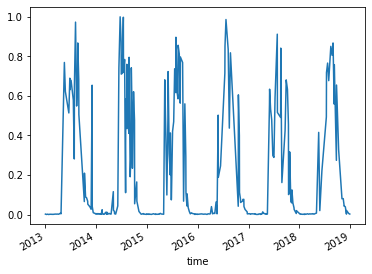

In [19]:
# First, calculate the number of snowy pixels in the study area for each timestep
snow_sum = snow_ds.sum(dim=['x', 'y'])

# Then calculate the number of pixels in the study area with valid data
# for each time step 
valid_sum = valid_ds.sum(dim=['x', 'y'])

# By dividing the number of snowy pixels by the number of valid pixels, we can
# compute a normalised percentage land cover that accounts for missing/invalid data
snow_prop = (snow_sum / valid_sum)

# Plot a line graph of snow cover across time as a proportion of the study area
snow_prop.plot()


#### Plot a smoothed time series
Due to issues with snow being confused for clouds in the satellite data, the above time series is very noisy and contains large fluctuations in the coverage of snow over short periods. To view a smoother, easier to interpret snow cover time series, we can take a rolling median of the data above. This will return the median of each observation and its four neighbours, resulting in a smoother dataset:

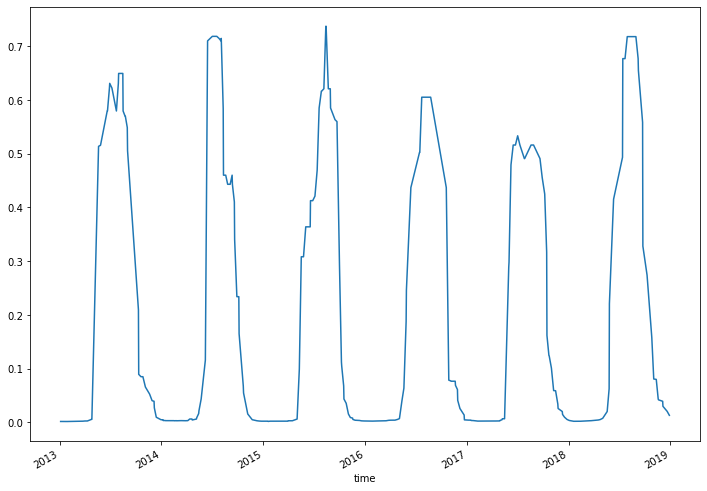

In [21]:
snow_prop.rolling(time=11, center=True, min_periods=1).median().plot(figsize=(12, 8))

## Plot snow accumulation for every pixel
As well as plotting a time series of snow cover across time, we can assess how frequently areas of the study area were covered by snow during the time period being analysed. 

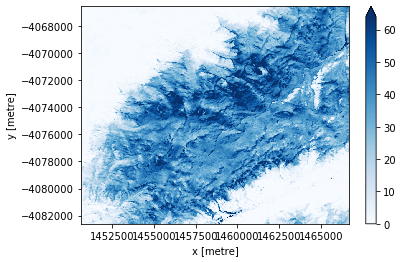

In [22]:
# This time, calculate the number of snowy observations for every pixel
# by taking a sum along the 'time' dimension
snow_sum_perpixel = snow_ds.sum(dim=['time'])

# Similarly, compute the number of valid observations for each pixel
# by taking the sum of valid observations along the 'time' dimension
valid_sum_perpixel = valid_ds.sum(dim=['time'])

# We can plot the raw number of snowy observations per pixel:
snow_sum_perpixel.plot(cmap='Blues', robust=True)

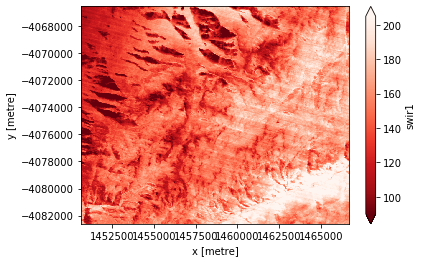

In [23]:
# We can also plot the number of valid observations for each pixel throughout 
# the time series. Red below represents pixels with very few valid observations, 
# due to either issues with terrain shadow, or snow being accidently mapped as cloud
valid_sum_perpixel.plot(cmap='Reds_r', robust=True)

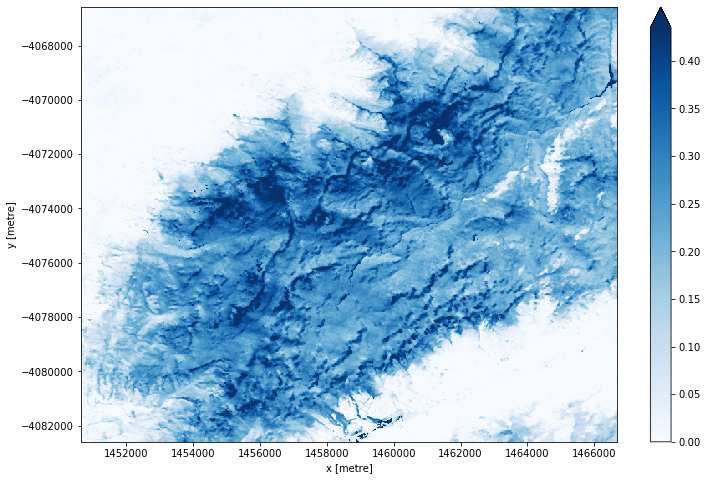

In [24]:
# Finally, we can normalise the raw number of snowy observations per pixel 
# by our total valid observations per pixel by dividing the two datasets:
snow_prop_perpixel = (snow_sum_perpixel / valid_sum_perpixel)

# Plot the resulting snow accumulation layer. The values here represent the 
# proportion of valid observations that each pixel was covered in snow, with
# blue colours representing pixels that were covered in snow for a significant
# portion of our valid observations:
snow_prop_perpixel.plot(cmap='Blues', robust=True, figsize=(12, 8))

## Advanced: compare snow extent elevation across time
Now that we have data on the distribution of snow for each satellite image, we can compare this to other datasets to provide more insights. Here we load a Digital Elevation Model dataset using the datacube, and use it to compare the elevation distribution of snow across time.

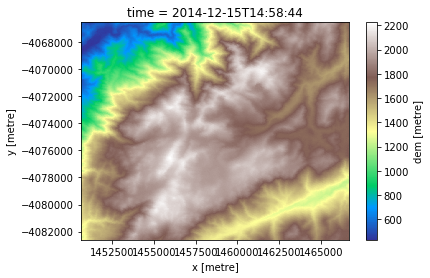

In [25]:
# Load the DEM data
dem_ds = dc.load(product='srtm_dem1sv1_0', **query)

# Plot the data
dem_ds.dem.plot(cmap='terrain')

We can return elevation data from the DEM for the area covered by snow in each timestep in our snow dataset:

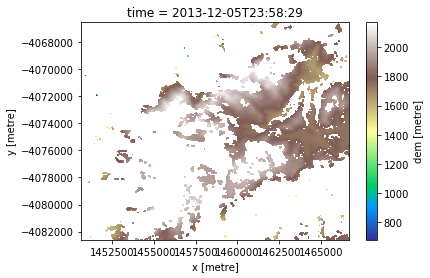

In [26]:
# Clip DEM to snow extent for every timestep
snow_elev_ds = dem_ds.dem.squeeze(dim='time').where(snow_ds)

# Plot example of clipped data for one timestep
snow_elev_ds.isel(time=40).plot(cmap='terrain')

We can plot the median elevation of the snow cover across time. However, this data can be extremely noisy, as it includes the elevation of small snow extents during summer and lower elevation pixels accidently mapped as snow:

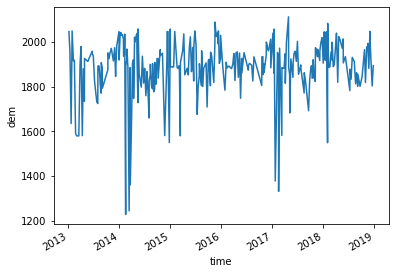

In [27]:
snow_elev_ts = snow_elev_ds.median(dim=['x', 'y'])
snow_elev_ts.plot()

A nicer way to visualise the data is using boxplots to summarise snow cover elevation for each year. This lets us compare the entire elevation range covered by snow annually:

Text(0.5, 0.98, 'Annual snow elevation distribution')

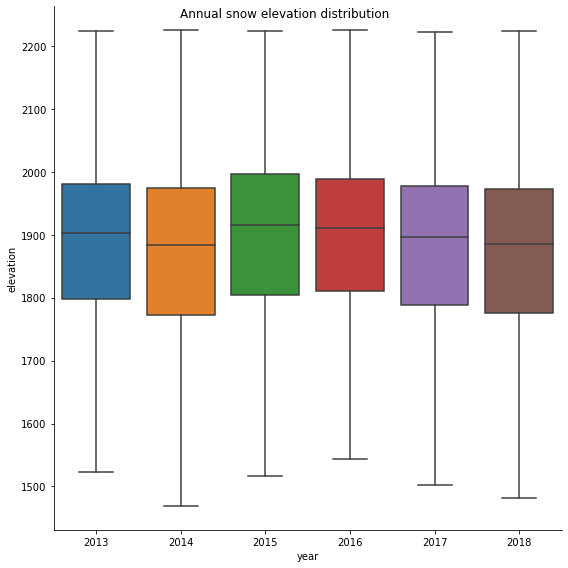

In [28]:
# Convert xarray data into a Pandas dataframe with one row per observation
snow_elev_df = (snow_elev_ds
                .stack(z=('x', 'y'))   # change the data from 4D (time, x, y) to 2D (time, location)
                .to_pandas()           # convert to a dataframe/table format
                .reset_index()         # turn the 'time' index into a normal column
                .melt(id_vars='time',  # rearrange the data to have one observation per row
                      value_name='elevation')
                .dropna()              # remove all empty observations (no snow)
                .sample(1000000))      # take a limited sample of rows to allow faster plotting

# Add a new column to allow summarising data by year
snow_elev_df['year'] = snow_elev_df.time.dt.year

# Plot each year's data as a boxplot to allow us to compare the elevation range
ax = sns.catplot(data=snow_elev_df, x='year', y='elevation', kind='box', showfliers=False, height=8)

# Add a title
ax.fig.suptitle('Annual snow elevation distribution')